In [1]:
# Amir Pourmand - 99210259

In [10]:
# Amir Pourmand (99210259)

import torchvision.datasets as ds
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_train = np.array(ds.FashionMNIST(root="./data", train=True, download=True).data)
target_train = np.array(ds.FashionMNIST(root="./data", train=True, download=True).targets)
data_test = np.array(ds.FashionMNIST(root="./data", train=False, download=True).data)
target_test = np.array(ds.FashionMNIST(root="./data", train=False, download=True).targets)

#data_train, target_train = shuffle(data_train, target_train)

#### Transform the data! ####
data_train =data_train / 255
data_test = data_test / 255

target_train=pd.get_dummies(target_train).values
target_test = pd.get_dummies(target_test).values

data_train=data_train.reshape((-1,28*28))
data_test = data_test.reshape((-1,28*28))


In [3]:
from IPython.core.debugger import set_trace


#Part 1

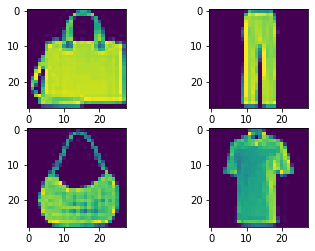

In [17]:
def show_grid_twobytwo(data):
    my_pic=data[np.random.randint(0,60000,4)]
    fig, axs = plt.subplots(2, 2)
    axs[0, 0].imshow(my_pic[0].reshape(28,28))
    axs[0, 1].imshow(my_pic[1].reshape(28,28))
    axs[1, 0].imshow(my_pic[2].reshape(28,28))
    axs[1, 1].imshow(my_pic[3].reshape(28,28))

show_grid_twobytwo(data_train)

#Part 2

In [176]:
class ReLU():
    def forward(self, x):
        self.old_x = np.copy(x)
        return np.clip(x,0,None)

    def backward(self, grad):
        return np.where(self.old_x>0,grad,0)

class Sigmoid():
    def forward(self, x):
        self.old_y = np.exp(x) / (1. + np.exp(x))
        return self.old_y

    def backward(self, grad):
        return self.old_y * (1. - self.old_y) * grad

class Softmax():
    def forward(self,x):
            self.old_y = np.exp(x) / np.exp(x).sum(axis=1) [:,None]
            return self.old_y

    def backward(self,grad):
            return self.old_y * (grad -(grad * self.old_y).sum(axis=1)[:,None])

class CrossEntropy():
    def forward(self,x,y):
            self.old_x = x.clip(min=1e-8,max=None)
            self.old_y = y
            return (np.where(y==1,-np.log(self.old_x), 0)).sum(axis=1)

    def backward(self):
            return np.where(self.old_y==1,-1/self.old_x, 0)


class Linear():
    def __init__(self,n_in,n_out,momentum=False):
        self.weights = np.random.randn(n_in,n_out) * np.sqrt(2/n_in)
        self.biases = np.zeros(n_out)

        self.momentum = momentum
        if momentum:
            self.grad_w =self.previous = np.zeros((n_in,n_out))

    def forward(self, x):
        self.old_x = x
        return np.dot(x,self.weights) + self.biases

    def backward(self,grad):
        self.grad_b = grad.mean(axis=0)

        if self.momentum:
            self.previous = self.grad_w

        self.grad_w = (np.matmul(self.old_x[:,:,None],grad[:,None,:])).mean(axis=0)
        return np.dot(grad,self.weights.transpose())




In [136]:
class Model():
    def __init__(self, layers, cost):
        self.layers = layers
        self.cost = cost

    def forward(self,x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def loss(self,x,y):
        self.output = self.forward(x)
        return self.cost.forward(self.output,y)

    def backward(self):
        grad = self.cost.backward()
        for i in range(len(self.layers)-1,-1,-1):
            grad = self.layers[i].backward(grad)

    def calculate_accuracy(self, real):
        predictedNumber = np.argmax(self.output,axis=1)
        realNumber = np.argmax(real,axis=1)
        return np.mean(predictedNumber == realNumber)


def train(model,lr,nb_epoch,data,label,batch_size=1000):
    loss_train = []
    loss_test = []

    accuracy_train = []
    accuracy_test = []
    for epoch in range(nb_epoch):
        lr = lr * 0.99
        if lr < 1e-3:
            lr = 1e-3

        num_inputs = 0
        running_loss = 0
        accuracy = 0

        number_of_batches = int(data.shape[0]/batch_size)
        for i in range(number_of_batches):
            input = data[i*batch_size:(i+1)*batch_size]
            output = label[i*batch_size:(i+1)*batch_size]
            num_inputs += input.shape[0]
            running_loss += model.loss(input,output).sum()
            model.backward()

            accuracy += model.calculate_accuracy(output)

            for layer in model.layers:
                if type(layer) == Linear:
                    layer.weights -= lr * layer.grad_w
                    layer.biases -= lr * layer.grad_b
        print(f'Epoch {epoch+1}/{nb_epoch}: loss train = {running_loss}')
        print(f'Train accuracy: {accuracy/number_of_batches}')

        loss_test_current = model.loss(data_test,target_test).sum()
        print(f'Epoch {epoch+1}/{nb_epoch}: loss test = {loss_test_current}')
        accuracy_current_test= model.calculate_accuracy(target_test)
        print(f'Test accuracy: {accuracy_current_test}')

        loss_train.append(running_loss)
        loss_test.append(loss_test_current)
        
        accuracy_train.append(accuracy/number_of_batches)
        accuracy_test.append(accuracy_current_test)
    return loss_train,loss_test,accuracy_train,accuracy_test

In [139]:
net = Model([Linear(784,128), Sigmoid(), Linear(128,64), Sigmoid(), Linear(64,10), Softmax()], CrossEntropy())

In [140]:
 epoch_count = 30
 loss_train,loss_test,accuracy_train,accuracy_test = train(net,1e-1,epoch_count,data_train,target_train)

Epoch 1/30: loss train = 132827.31534895362
Train accuracy: 0.3532333333333334
Epoch 1/30: loss test = 20946.296056284016
Test accuracy: 0.4632
Epoch 2/30: loss train = 117172.60599323544
Train accuracy: 0.5205333333333333
Epoch 2/30: loss test = 17953.662677965036
Test accuracy: 0.5687
Epoch 3/30: loss train = 98626.18946359388
Train accuracy: 0.6223333333333333
Epoch 3/30: loss test = 15075.571274081087
Test accuracy: 0.66
Epoch 4/30: loss train = 83943.86310049995
Train accuracy: 0.6666999999999998
Epoch 4/30: loss test = 13095.937413259353
Test accuracy: 0.6757
Epoch 5/30: loss train = 73973.71860094678
Train accuracy: 0.6827666666666665
Epoch 5/30: loss test = 11739.020457773331
Test accuracy: 0.6895
Epoch 6/30: loss train = 66933.03985993215
Train accuracy: 0.6955500000000002
Epoch 6/30: loss test = 10751.809601783323
Test accuracy: 0.6981
Epoch 7/30: loss train = 61667.876132650716
Train accuracy: 0.7071833333333334
Epoch 7/30: loss test = 9995.114571604656
Test accuracy: 0.7081

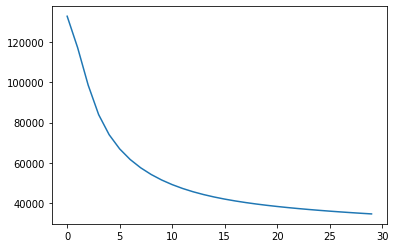

In [141]:
plt.plot(np.arange(epoch_count), loss_train)

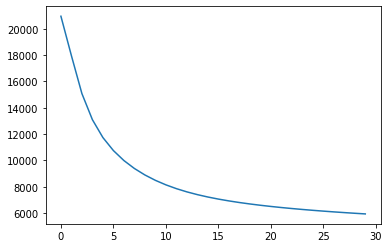

In [142]:
plt.plot(np.arange(epoch_count), loss_test)

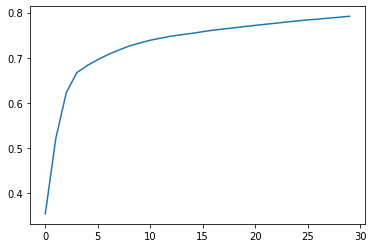

In [143]:
plt.plot(np.arange(epoch_count), accuracy_train)

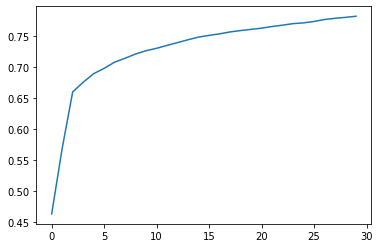

In [144]:
plt.plot(np.arange(epoch_count), accuracy_test)

# Part 3

In [146]:
net2 = Model([Linear(784,128), ReLU(), Linear(128,64), ReLU(), Linear(64,10), Softmax()], CrossEntropy())

In [147]:
 epoch_count = 30
 loss_train,loss_test,accuracy_train,accuracy_test = train(net,1e-1,epoch_count,data_train,target_train)

Epoch 1/30: loss train = 34273.999245328014
Train accuracy: 0.7943333333333332
Epoch 1/30: loss test = 5882.024706903974
Test accuracy: 0.7845
Epoch 2/30: loss train = 33891.26773555227
Train accuracy: 0.7967333333333333
Epoch 2/30: loss test = 5823.962497812203
Test accuracy: 0.7865
Epoch 3/30: loss train = 33530.60173532922
Train accuracy: 0.7998333333333332
Epoch 3/30: loss test = 5769.388843975354
Test accuracy: 0.7884
Epoch 4/30: loss train = 33190.318871548116
Train accuracy: 0.8021333333333331
Epoch 4/30: loss test = 5717.999626335039
Test accuracy: 0.7909
Epoch 5/30: loss train = 32868.717160099586
Train accuracy: 0.8039666666666668
Epoch 5/30: loss test = 5669.53330350921
Test accuracy: 0.793
Epoch 6/30: loss train = 32564.331491516987
Train accuracy: 0.8061499999999999
Epoch 6/30: loss test = 5623.76092580437
Test accuracy: 0.7947
Epoch 7/30: loss train = 32275.88105378048
Train accuracy: 0.8082166666666668
Epoch 7/30: loss test = 5580.479400607843
Test accuracy: 0.7966
Epoch

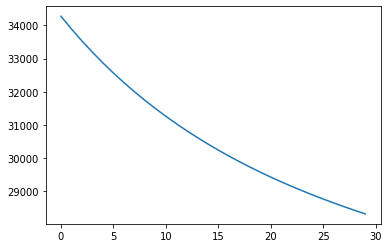

In [148]:
plt.plot(np.arange(epoch_count), loss_train)

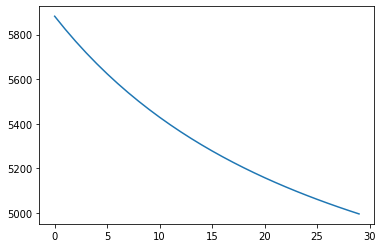

In [149]:
plt.plot(np.arange(epoch_count), loss_test)

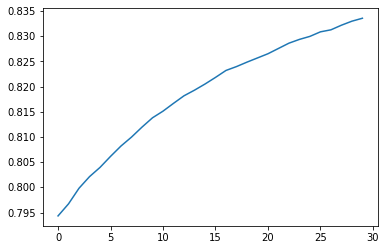

In [150]:
plt.plot(np.arange(epoch_count), accuracy_train)

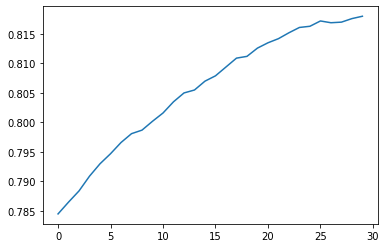

In [151]:
plt.plot(np.arange(epoch_count), accuracy_test)

#Part 4

In [179]:
class Model():
    def __init__(self, layers, cost):
        self.layers = layers
        self.cost = cost

    def forward(self,x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def loss(self,x,y):
        self.output = self.forward(x)
        return self.cost.forward(self.output,y)

    def backward(self):
        grad = self.cost.backward()
        for i in range(len(self.layers)-1,-1,-1):
            grad = self.layers[i].backward(grad)
    
    def step(self,lr):
        for layer in self.layers:
                if type(layer) == Linear:
                    layer.previous = lr* layer.grad_w +momentum_rate*layer.previous
                    layer.weights -= layer.previous
                    layer.biases -= lr * layer.grad_b

    def calculate_accuracy(self, real):
        predictedNumber = np.argmax(self.output,axis=1)
        realNumber = np.argmax(real,axis=1)
        return np.mean(predictedNumber == realNumber)


def train_momentum(model,lr,nb_epoch,data,label,batch_size=1000):
    loss_train = []
    loss_test = []

    accuracy_train = []
    accuracy_test = []
    for epoch in range(nb_epoch):
        lr = lr * 0.99
        if lr < 1e-3:
            lr = 1e-3

        num_inputs = 0
        running_loss = 0
        accuracy = 0

        number_of_batches = int(data.shape[0]/batch_size)
        for i in range(number_of_batches):
            input = data[i*batch_size:(i+1)*batch_size]
            output = label[i*batch_size:(i+1)*batch_size]
            num_inputs += input.shape[0]
            running_loss += model.loss(input,output).sum()
            model.backward()

            accuracy += model.calculate_accuracy(output)
            model.step(lr)
            
        print(f'Epoch {epoch+1}/{nb_epoch}: loss train = {running_loss}')
        print(f'Train accuracy: {accuracy/number_of_batches}')

        loss_test_current = model.loss(data_test,target_test).sum()
        print(f'Epoch {epoch+1}/{nb_epoch}: loss test = {loss_test_current}')
        accuracy_current_test= model.calculate_accuracy(target_test)
        print(f'Test accuracy: {accuracy_current_test}')

        loss_train.append(running_loss)
        loss_test.append(loss_test_current)
        
        accuracy_train.append(accuracy/number_of_batches)
        accuracy_test.append(accuracy_current_test)
    return loss_train,loss_test,accuracy_train,accuracy_test

In [180]:
net = Model([Linear(784,128,True), Sigmoid(), Linear(128,64,True), Sigmoid(), Linear(64,10,True), Softmax()], CrossEntropy())
epoch_count = 30
loss_train,loss_test,accuracy_train,accuracy_test = train_momentum(net,1e-1,epoch_count,data_train,target_train)

Epoch 1/30: loss train = 103761.94796602237
Train accuracy: 0.3747833333333334
Epoch 1/30: loss test = 11689.498285159467
Test accuracy: 0.538
Epoch 2/30: loss train = 58272.40424204931
Train accuracy: 0.6165
Epoch 2/30: loss test = 9527.279536904098
Test accuracy: 0.6295
Epoch 3/30: loss train = 46150.98579169021
Train accuracy: 0.6966333333333334
Epoch 3/30: loss test = 7587.40233664309
Test accuracy: 0.7029
Epoch 4/30: loss train = 41056.18575142075
Train accuracy: 0.7314666666666665
Epoch 4/30: loss test = 7156.556337217709
Test accuracy: 0.729
Epoch 5/30: loss train = 38149.82667771503
Train accuracy: 0.7510833333333333
Epoch 5/30: loss test = 6572.531684206939
Test accuracy: 0.7462
Epoch 6/30: loss train = 35604.57046914616
Train accuracy: 0.7713333333333338
Epoch 6/30: loss test = 5814.691801247
Test accuracy: 0.7793
Epoch 7/30: loss train = 34009.61060029159
Train accuracy: 0.7833666666666667
Epoch 7/30: loss test = 5458.487971309901
Test accuracy: 0.7955
Epoch 8/30: loss train

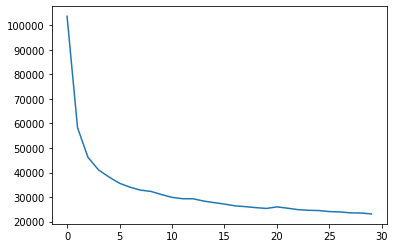

In [181]:
plt.plot(np.arange(epoch_count), loss_train)

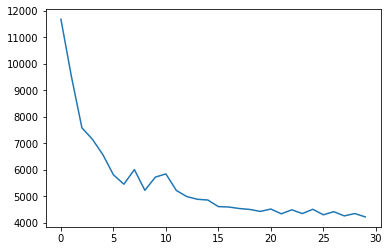

In [182]:
plt.plot(np.arange(epoch_count), loss_test)

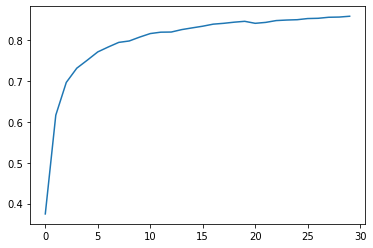

In [183]:
plt.plot(np.arange(epoch_count), accuracy_train)

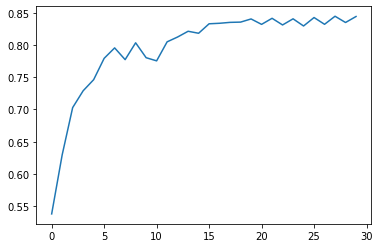

In [184]:
plt.plot(np.arange(epoch_count), accuracy_test)

#Part 5

In [158]:
net = Model([Linear(784,128), Sigmoid(), Linear(128,64), Sigmoid(), Linear(64,64), Sigmoid(), Linear(64,10), Softmax()], CrossEntropy())
epoch_count = 30
loss_train,loss_test,accuracy_train,accuracy_test = train(net,1e-1,epoch_count,data_train,target_train)

Epoch 1/30: loss train = 138585.16783004766
Train accuracy: 0.17660000000000003
Epoch 1/30: loss test = 22762.64773987977
Test accuracy: 0.2118
Epoch 2/30: loss train = 135560.2365353218
Train accuracy: 0.2977166666666667
Epoch 2/30: loss test = 22382.228178991583
Test accuracy: 0.3337
Epoch 3/30: loss train = 132365.951542139
Train accuracy: 0.3427333333333334
Epoch 3/30: loss test = 21645.577227901616
Test accuracy: 0.3456
Epoch 4/30: loss train = 126037.53291557218
Train accuracy: 0.3608500000000001
Epoch 4/30: loss test = 20229.266243685433
Test accuracy: 0.3469
Epoch 5/30: loss train = 115819.46039339514
Train accuracy: 0.38485
Epoch 5/30: loss test = 18383.926078942066
Test accuracy: 0.3973
Epoch 6/30: loss train = 105550.65833693123
Train accuracy: 0.4200333333333332
Epoch 6/30: loss test = 16907.74045055039
Test accuracy: 0.4585
Epoch 7/30: loss train = 97911.1664760458
Train accuracy: 0.46083333333333343
Epoch 7/30: loss test = 15818.818293374112
Test accuracy: 0.4981
Epoch 8/

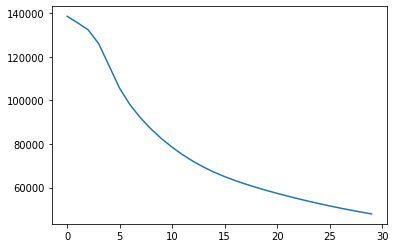

In [159]:
plt.plot(np.arange(epoch_count), loss_train)

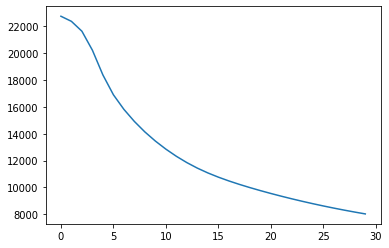

In [160]:
plt.plot(np.arange(epoch_count), loss_test)

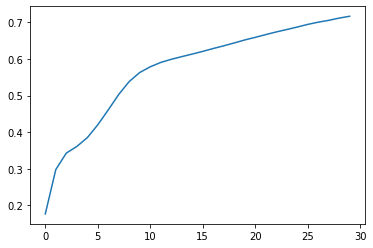

In [161]:
plt.plot(np.arange(epoch_count), accuracy_train)

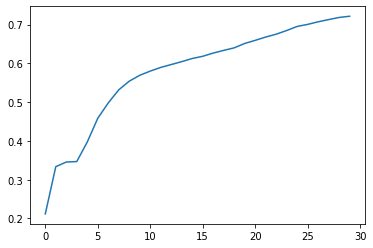

In [162]:
plt.plot(np.arange(epoch_count), accuracy_test)

#Part 6

In [218]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [219]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.FashionMNIST(root="./data", download=True, train=True, transform=transform)
valset = datasets.FashionMNIST(root="./data", download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.Sigmoid(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.Sigmoid(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


In [220]:
criterion = nn.CrossEntropyLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) 
loss = criterion(logps, labels)

In [221]:
optimizer = optim.SGD(model.parameters(), lr=0.03)
time0 = time()

loss_train = []
accuracy_train = []
accuracy_test = []

epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        loss_train.append(running_loss)
        accuracy_train.append(calculate_accuracy(trainloader,'train'))
        accuracy_test.append(calculate_accuracy(valloader,'test'))


print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 2.3021124784372002
Number Of Images Tested = 60000

Model Accuracy for train= 0.12763333333333332
Number Of Images Tested = 10000

Model Accuracy for test= 0.1302
Epoch 1 - Training loss: 2.300212318709156
Number Of Images Tested = 60000

Model Accuracy for train= 0.10668333333333334
Number Of Images Tested = 10000

Model Accuracy for test= 0.1069
Epoch 2 - Training loss: 2.297341703860236
Number Of Images Tested = 60000

Model Accuracy for train= 0.11051666666666667
Number Of Images Tested = 10000

Model Accuracy for test= 0.1097
Epoch 3 - Training loss: 2.2911456797931242
Number Of Images Tested = 60000

Model Accuracy for train= 0.13371666666666668
Number Of Images Tested = 10000

Model Accuracy for test= 0.1314
Epoch 4 - Training loss: 2.2720074648541937
Number Of Images Tested = 60000

Model Accuracy for train= 0.22395
Number Of Images Tested = 10000

Model Accuracy for test= 0.222
Epoch 5 - Training loss: 2.231057080124487
Number Of Images Tested = 60000


In [222]:
def calculate_accuracy(loader,label):  
    correct_count, all_count = 0, 0
    for images,labels in loader:
        for i in range(len(labels)):
            img = images[i].view(1, 784)
            with torch.no_grad():
                logps = model(img)

            
            ps = torch.exp(logps)
            probab = list(ps.numpy()[0])
            pred_label = probab.index(max(probab))
            true_label = labels.numpy()[i]
            if(true_label == pred_label):
                correct_count += 1
            all_count += 1

    print("Number Of Images Tested =", all_count)
    print("\nModel Accuracy for " + label +"=", (correct_count/all_count))
    return correct_count/all_count

In [223]:
calculate_accuracy(valloader,'test')

Number Of Images Tested = 10000

Model Accuracy for test= 0.6143


0.6143

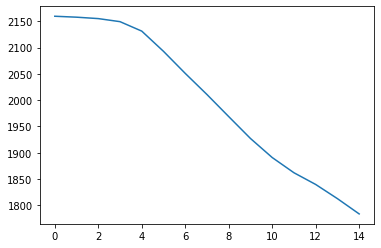

In [224]:
plt.plot(np.arange(15), loss_train)

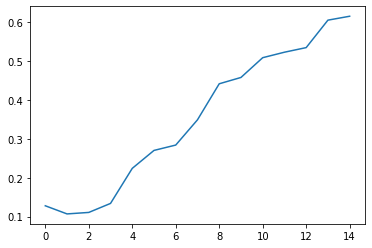

In [225]:
plt.plot(np.arange(15), accuracy_train)

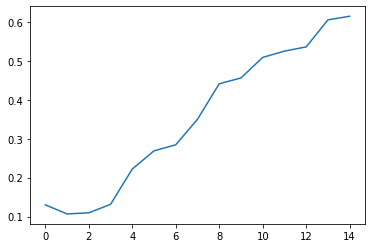

In [226]:
plt.plot(np.arange(15), accuracy_test)